## Imports

In [1]:
import sys, os, glob, time , corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0,'/home/isha/gw_detection_ias')
import utils as pipeline_utils
import time

from importlib import reload

# cogwheel imports
sys.path.append('/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel')
import cogwheel
from cogwheel import utils , data, sampling, gw_plotting, posterior, prior

from cogwheel.factorized_qas import IntrinsicParametersPrior, MarginalizedRelativeBinningLikelihood
from cogwheel.population_inference.test_combined_priors import TestPrior
from cogwheel.population_inference.test_combined_priors import FixedTestPopulationPrior, FixedTestPrior, TestingGaussianChieff, GaussianChieff
from cogwheel.population_inference.test_combined_priors import FixedDistancePrior, FixedInclinationPrior, GaussianTestPrior

from cogwheel.population_inference.injection_priors import InjectionPrior, InjectionMassPrior
from cogwheel.population_inference.population_models import ParametrizedPrior, CombinedParametrizedPrior, HyperPrior
from cogwheel.population_inference.population_likelihood import PopulationLikelihood
from cogwheel.gw_prior import extrinsic

from cogwheel.population_inference.population_posterior import PopulationPosterior

from cogwheel.prior import Prior, UniformPriorMixin, IdentityTransformMixin, CombinedPrior

/home/isha/miniconda3/envs/cogwheel_pop_latest/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/tmp/ipykernel_306442/1466965261.py:17: DeprecationWarning: 
The `factorized_qas` subpackage is deprecated.
The preferred way of marginalizing extrinsic parameters is now
`cogwheel.likelihood.MarginalizedExtrinsicLikelihoodQAS`
coupled to e.g. `gw_prior.IntrinsicAlignedSpinIASPrior`.
See  `tutorials/f

In [2]:
# #!/usr/bin/env python
# import psutil
# # gives a single float value
# psutil.cpu_percent()
# # gives an object with many fields
# psutil.virtual_memory()
# # you can convert that object to a dictionary 
# dict(psutil.virtual_memory()._asdict())

In [3]:
# import os
# print(os.environ['CONDA_DEFAULT_ENV'])

## Load injection summary data

In [4]:
injs_summary = pd.read_pickle('injections_summary.pkl')

In [5]:
injs_summary.keys()

Index(['t_rec_h', 't_rec_l', 'rhosq_rec_h', 'rhosq_rec_l', 'normfac_h',
       'normfac_l', 'dphi_rec', 'sb_rec', 'inds', 'cosiota', 'costhetanet',
       'phinet_hat', 't_refdet', 'psi', 'phi_ref_hat', 'm1_source', 'cum_q',
       'd_hat', 'chieff', 'cumchidiff', 'iota', 'ra', 'dec', 't_geocenter',
       'phi_ref', 'm1', 'm2', 'd_luminosity', 's1z', 's2z', 's1x', 's1y',
       's2x', 's2y', 'l1', 'l2', 'f_ref', 'm2_source', 'q', 'mchirp', 'mtot',
       'lnq', 'q1', 'eta', 'chia', 's1', 's1costheta', 's1theta', 's1phi',
       's2', 's2costheta', 's2theta', 's2phi', 'chip', 'phi_H', 'tgps',
       'mchirp_id', 'dt_linfree', 'ln_pdet_fid', 'campaign', 'pdet_fid',
       'dt_closest_inj', 'ifar', 'ifar_no_coherent_score'],
      dtype='object')

### testing dataframe -> dictionary 

In [5]:
dict_example = {'a':np.asarray([1,2,3,4,5]), 'b':np.asarray([6,7,8,9,10]), 'c':np.asarray([11,12,13,14, 15])}
df_example = pd.DataFrame(dict_example)
df_example[np.array(['a','b'])]

dict_of_arrays = {col: df_example[col].to_numpy() for col in df_example.columns}
display(df_example)
print(dict_of_arrays)

,a,b,c
0,1,6,11
1,2,7,12
2,3,8,13
3,4,9,14
4,5,10,15


{'a': array([1, 2, 3, 4, 5]), 'b': array([ 6,  7,  8,  9, 10]), 'c': array([11, 12, 13, 14, 15])}


In [6]:
df_example

,a,b,c
0,1,6,11
1,2,7,12
2,3,8,13
3,4,9,14
4,5,10,15


In [8]:
dict_example2 = {'v':np.asarray([1,2,3,4,5]), 'w':np.asarray([6,7,8,9,10]), 'f':np.asarray([11,12,13,14, 15])}
df_example2 = pd.DataFrame(dict_example2)
# df_example2[np.array(['a','b'])]

# dict_of_arrays = {col: df_example[col].to_numpy() for col in df_example.columns}
# display(df_example)
# print(dict_of_arrays)

In [10]:
df_example.join(df_example2)

,a,b,c,v,w,f
0,1,6,11,1,6,11
1,2,7,12,2,7,12
2,3,8,13,3,8,13
3,4,9,14,4,9,14
4,5,10,15,5,10,15


## Creating Prior Class Instances

In [5]:
parentdir = '/home/isha/PopulationSelectionEffects/output/'

# grab the psds from any exisiting event - we will chnage the event name later
eventname = 'GW190521'

combined_pop_prior = FixedTestPopulationPrior(f_ref=20) # combined prior
pop_prior = GaussianTestPopulationPrior() # population prior
#test_prior = TestPrior(detector_pair='HL', tgps=0.0, ref_det_name='H1', f_avg='10',f_ref=20)
#fixed_test_prior = FixedTestPrior(f_ref=20)
#inj_prior=InjectionPrior(detector_pair='HL', tgps=0.0, ref_det_name='H1', f_avg='10', m1_source_range=(3,10))
#,f_ref=20)
#inj_mass_prior = InjectionMassPrior(tgps=0.0, ref_det_name='H1',m1_source_range=(3,10))
inj_prior=InjectionPrior(detector_pair='HL', tgps=0.0, ref_det_name='H', f_avg=10, m1_source_range=(3,10),f_ref=20)

In [6]:
pop_prior.hyperparam_range_dic

{'lambda1': (10, 10), 'lambda2': (-10, 10)}

In [7]:
# display the pop objects
combined_pop_prior, pop_prior

(FixedTestPopulationPrior(m1, m2) → [iota, ra, dec, t_geocenter, psi, phi_ref, m1, m2, s1z, s2z, s1x_n, s1y_n, s2x_n, s2y_n, l1, l2, f_ref, d_luminosity],
 GaussianTestPopulationPrior(m1, m2) → [m1, m2])

In [8]:
inj_prior.subpriors

[IsotropicInclinationPrior(cosiota) → [iota],
 IsotropicSkyLocationPrior(costhetanet, phinet_hat | iota) → [ra, dec],
 UniformTimePrior(t_refdet | ra, dec) → [t_geocenter],
 UniformPolarizationPrior(psi) → [psi],
 UniformPhasePrior(phi_ref_hat | iota, ra, dec, psi, t_geocenter) → [phi_ref],
 InjectionMassPrior(m1_source, cum_q, d_hat | ra, dec, psi, iota) → [m1, m2, d_luminosity],
 UniformEffectiveSpinPrior(chieff, cumchidiff | m1, m2) → [s1z, s2z],
 ZeroInplaneSpinsPrior() → [s1x_n, s1y_n, s2x_n, s2y_n],
 ZeroTidalDeformabilityPrior() → [l1, l2],
 FixedReferenceFrequencyPrior() → [f_ref]]

## Load PE samples

In [6]:
#read pe samples from saved 
samples_root_dir = '/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/PE_samples10'
list_events = ['GW150914', 'GW151012', 'GW151216', 
               'GW151226', 'GW170104', 'GW170121', 'GW170202', 'GW170304', 'GW170403', 'GW170425']
all_events_pe = []
for event in list_events:
    event_file_name = os.path.join(samples_root_dir, event+'.feather')
    samples = pd.read_feather(event_file_name)
    all_events_pe.append(samples)

In [7]:
all_events_pe[0].keys()
#all_events_pe[0]['lnl']

Index(['mchirp', 'lnq', 'chieff', 'cumchidiff', 'costheta_jn', 'phi_jl_hat',
       'phi12', 'cums1r_s1z', 'cums2r_s2z', 'psi', 'costhetanet', 'phinet_hat',
       't_refdet', 'phi_ref_hat', 'weights', 'f_ref', 'm1', 'm2', 's1z', 's2z',
       'iota', 's1x_n', 's1y_n', 's2x_n', 's2y_n', 'ra', 'dec', 't_geocenter',
       'phi_ref', 'l1', 'l2', 'd_luminosity', 'lnl', 'lnl_aux_H', 'lnl_aux_L',
       'cosiota', 'm1_source', 'cum_q', 'd_hat'],
      dtype='object')

## Compute Likelihood

In [17]:
# now compute likelihood
injections_summary_dict = {'Ninj':20000, 'recovered_injections':injs_summary, 'pastro_func':np.ones(10)}
R0 = 70

likelihood_object = PopulationLikelihood(combined_pop_prior, injections_summary_dict, all_events_pe, R0, injection_population_model=inj_prior)

In [15]:
combined_pop_prior.prior_classes[5].get_init_dict()

NameError: name 'hyperparams_range_dic' is not defined

In [10]:
likelihood_object.w_i(hyperparams_dic={'lambda1':1, 'lambda2':1, 'R':100})

KeyboardInterrupt: 

In [18]:
likelihood_object.lnlike(hyperparams_dic={'lambda1':1, 'lambda2':1, 'R':100})

KeyboardInterrupt: 

## test lnprior again - vectorize too slow

In [6]:
gaussian_chieff = GaussianChieff()
lnprior_input_dict = {'chieff': all_events_pe[0]['chieff'], 'chieff_mean': 0, 'chieff_sigma':0.5}
gaussian_chieff.lnprior(**lnprior_input_dict)

0       -0.579843
1       -0.230335
2       -0.560441
3       -0.362299
4       -1.235035
           ...   
23611   -0.228898
23612   -0.248511
23613   -0.240653
23614   -0.231857
23615   -0.249587
Name: chieff, Length: 23616, dtype: float64

In [7]:
# figure out how to change the combined lnprior to make it work
test_gaussian_chieff_model = TestingGaussianChieff(detector_pair='HL', tgps=0.0, ref_det_name='H', f_avg=10, f_ref=20)

In [8]:
hyperparams_dic = {'R':60, 'chieff_mean': 0, 'chieff_sigma':0.5}

pe_param_keys = np.array(test_gaussian_chieff_model.sampled_params)
pe_model_params_df = all_events_pe[0][pe_param_keys]
model_params_dict = {col: pe_model_params_df[col].to_numpy() for col in pe_model_params_df.columns}
model_params_dict.update(hyperparams_dic)

test_gaussian_chieff_model.lnprior(**model_params_dict)

TypeError: unhashable type: 'numpy.ndarray'

In [9]:
%debug

> /home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py(178)transform()
    176                              for par in (subprior.sampled_params
    177                                          + subprior.conditioned_on)}
--> 178                 par_dic.update(subprior.transform(**input_dic))
    179             return {par: par_dic[par] for par in self.standard_params}
    180 



ipdb>  type(input_dic)


<class 'dict'>


ipdb>  input_dic.keys()


dict_keys(['cosiota'])


ipdb>  subprior


IsotropicInclinationPrior(cosiota) → [iota]


ipdb>  subprior.transform(**input_dic)


*** TypeError: unhashable type: 'numpy.ndarray'


ipdb>  type(input_dic['cosiota'])


<class 'numpy.ndarray'>
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [20]:
import copy

In [18]:
# transform_function**all_events_pe[0][['cosiota', 'm1']]

In [21]:
mydf = copy.deepcopy(all_events_pe[0])

In [25]:
test_gaussian_chieff_model.subpriors[0].transform_samples(mydf)

In [26]:
mydf.keys()

Index(['mchirp', 'lnq', 'chieff', 'cumchidiff', 'costheta_jn', 'phi_jl_hat',
       'phi12', 'cums1r_s1z', 'cums2r_s2z', 'psi', 'costhetanet', 'phinet_hat',
       't_refdet', 'phi_ref_hat', 'weights', 'f_ref', 'm1', 'm2', 's1z', 's2z',
       'iota', 's1x_n', 's1y_n', 's2x_n', 's2y_n', 'ra', 'dec', 't_geocenter',
       'phi_ref', 'l1', 'l2', 'd_luminosity', 'lnl', 'lnl_aux_H', 'lnl_aux_L',
       'cosiota', 'm1_source', 'cum_q', 'd_hat'],
      dtype='object')

In [27]:
test_gaussian_chieff_model.subpriors[0]

IsotropicInclinationPrior(cosiota) → [iota]

In [32]:
np.allclose(all_events_pe[0]['iota'].values, mydf['iota'].values)

True

In [10]:
from cogwheel.gw_prior.extrinsic import IsotropicInclinationPrior
transform_function = IsotropicInclinationPrior.transform

In [15]:
cosiota_dict = {'cosiota': tuple(model_params_dict['cosiota'])}

In [16]:
transform_function(**cosiota_dict)

{'iota': array([0.56906014, 2.62934537, 2.5807148 , ..., 2.8562522 ,
        2.83468156, 2.81271111])}

## Testing functions to create classes 

In [52]:
def create_uniform_hyperparam_prior_class(hyperparam_range_dic):
    class UniformHyperparamPrior(UniformPriorMixin, IdentityTransformMixin, Prior):
        def __init__(self):
            self.standard_params = list(hyperparam_range_dic)
            self.range_dic = hyperparam_range_dic
        def get_init_dict():
            return hyperparam_range_dic
    return UniformHyperparamPrior

In [53]:
UniformHyperparamPrior1 = create_uniform_hyperparam_prior_class(pop_prior.hyperparam_range_dic)

In [54]:
uniform_prior = UniformHyperparamPrior1()
uniform_prior.standard_params

['lambda1', 'lambda2']

In [68]:
def create_combined_hyperparam_class(hyperparam_prior_class_list):
    class CombinedHyperparamPrior(CombinedPrior):
        prior_classes = hyperparam_prior_class_list
    return CombinedHyperparamPrior

In [69]:
combined_prior_class = create_combined_hyperparam_class([FixedDistancePrior, FixedInclinationPrior, GaussianTestPrior])

In [65]:
combined_prior_class()

CombinedHyperparamPrior(m1, m2) → [d_luminosity, iota, m1, m2]

In [61]:
%debug

> /home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/prior.py(600)_set_params()
    598         """
    599         cls.range_dic = {}
--> 600         for prior_class in cls.prior_classes:
    601             cls.range_dic.update(prior_class.range_dic)
    602 



ipdb>  cls.prior_classes


ipdb>  prior_class


*** NameError: name 'prior_class' is not defined
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


## Testing vecrtorized functions

In [ ]:
par_dict2 = {'m1':np.array([5,4,3,2,1]), 'm2':np.array([5,4,3,2,1]), 'lambda1':5, 'lambda2':5}
lnprior_func1 = np.vectorize(pop_prior.lnprior)
lnprior_func2 = np.vectorize(pop_prior2.lnprior)
lnprior_func1(**par_dict)

In [12]:
lnprior_func2(**par_dict2)

array([ 4.15358748e+00, -3.95846413e+02, -1.59584641e+03,
       -3.59584641e+03, -6.39584641e+03])

In [11]:
pop_prior2.lnprior(m1=5, m2=5, lambda1=5, lambda2=5)

4.153587480698636

In [17]:
inj_mass_prior.sampled_params

['m1_source', 'cum_q', 'd_hat']

In [22]:
issubclass(GaussianTestPopulationPrior, prior.Prior)

True

## Test creating ParametrizedPrior class

In [13]:
obj = GaussianHyperparams()

In [14]:
obj.standard_params

['lambda1', 'lambda2']

In [31]:
ex = []
for i in [['abc','b'], 'abc', 'b']:
    print(i)
    ex.append(i)
    print(ex)
ex

['abc', 'b']
[['abc', 'b']]
abc
[['abc', 'b'], 'abc']
b
[['abc', 'b'], 'abc', 'b']


[['abc', 'b'], 'abc', 'b']

In [32]:
set(ex)

TypeError: unhashable type: 'list'

## Test new CombinedParametrizedPrior class

In [8]:
combined_pop_prior = FixedTestPopulationPrior(f_ref=20) # combined prior
#pop_prior = GaussianTestParametrizedPrior() # population prior

In [9]:
test_gaussian_chieff_model = TestingGaussianChieff(detector_pair='HL', tgps=0.0, ref_det_name='H', f_avg=10, f_ref=20)

In [10]:
inj_prior=InjectionPrior(detector_pair='HL', tgps=0.0, ref_det_name='H', f_avg=10, 
                         m1_source_range=(3,10),f_ref=20)

In [11]:
# now compute likelihood
injections_summary_dict = {'Ninj':20000, 'recovered_injections':injs_summary, 'pastro_func':np.ones(10)}
R0 = 70

likelihood_object = PopulationLikelihood(test_gaussian_chieff_model, injections_summary_dict, 
                                         all_events_pe, R0, injection_population_model=inj_prior)

In [12]:
all_events_pe[0][0:1000]

,mchirp,lnq,chieff,cumchidiff,costheta_jn,phi_jl_hat,phi12,cums1r_s1z,cums2r_s2z,psi,...,l1,l2,d_luminosity,lnl,lnl_aux_H,lnl_aux_L,cosiota,m1_source,cum_q,d_hat
0,27.217838,-0.326421,-0.420744,0.473716,0.860835,2.808493,5.150784,0.565569,0.074162,0.502546,...,0,0,14538.618015,17.651377,-7.535559,0.022812,0.842408,12.920480,0.698139,1486.386272
1,27.883631,-1.415661,-0.047662,0.580546,-0.772647,2.123236,2.051186,0.975445,0.002229,1.001872,...,0,0,13415.883071,19.889506,-5.116327,-0.867061,-0.871645,24.866374,0.211037,1535.442089
2,31.593108,-1.652429,0.409053,0.808564,-0.872931,0.525684,6.065270,0.997342,0.260092,0.118174,...,0,0,14599.554121,19.515602,-1.369294,-4.347512,-0.846788,30.805049,0.164461,1455.800048
3,31.710681,-1.125810,0.261255,0.167585,-0.653827,0.520674,4.756114,0.573338,0.380377,0.048449,...,0,0,10633.162410,19.911462,-2.531102,-5.078593,-0.751559,27.027378,0.298432,904.401148
4,39.650934,-0.516392,0.710368,0.106841,0.709171,4.964519,1.726666,0.073706,0.683266,2.826287,...,0,0,13260.487511,19.405925,-5.496525,-1.040660,0.643362,21.805644,0.577284,1644.651767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37.280908,-2.719508,0.210535,0.620774,0.952510,0.207888,3.199565,0.252161,0.684465,1.354968,...,0,0,14486.063437,28.391853,1.481060,-0.321018,0.657995,67.716079,0.051906,1057.592815
996,35.783101,-0.089759,0.204701,0.069442,-0.238195,4.826735,5.490625,0.851901,0.095950,0.834537,...,0,0,11488.768391,28.440818,0.624018,0.506719,0.074553,16.981351,0.908780,9443.380534
997,31.907496,-0.098463,-0.856501,0.103681,-0.364915,0.730155,5.623870,0.019756,0.377616,2.703881,...,0,0,12947.814141,28.530511,1.976326,-0.670142,-0.565543,14.322692,0.899190,2440.666397
998,27.653464,-1.709654,0.352209,0.484149,-0.626218,5.453936,5.354728,0.318438,0.984579,1.011548,...,0,0,2063.513999,28.535499,1.493455,3.519448,-0.243167,58.080081,0.166579,501.649514


## Timing the lnprior and likelihood computations

In [13]:
import copy

In [14]:
mydf = copy.deepcopy(all_events_pe[0])
test_hyp_dic = {'chieff_mean':0, 'chieff_sigma':1, 'R':100}

In [15]:
len(mydf)

23616

In [16]:
# %%prun 
# zz = likelihood_object.lnlike(test_hyp_dic)

In [17]:
# likelihood_object.parametrized_population.transform_samples(samples)

In [16]:
%%prun
zz = likelihood_object.parametrized_population.lnprior_and_transform_samples(mydf[0:1000], **test_hyp_dic, force_update=False)

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_

         64858 function calls (64648 primitive calls) in 0.055 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     6006    0.011    0.000    0.038    0.000 function_base.py:2356(func)
     5000    0.008    0.000    0.024    0.000 prior.py:812(lnprior)
     5039    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     5000    0.004    0.000    0.012    0.000 fromnumeric.py:71(_wrapreduction)
     5000    0.003    0.000    0.015    0.000 fromnumeric.py:2979(prod)
     1001    0.002    0.000    0.002    0.000 test_combined_priors.py:129(lnprior)
     5000    0.002    0.000    0.002    0.000 fromnumeric.py:72(<dictcomp>)
       10    0.002    0.000    0.041    0.004 function_base.py:2443(_vectorize_call)
     6006    0.001    0.000    0.001    0.000 {method 'update' of 'dict' objects}
       32    0.001    0.000    0.001    0.000 take.py:120(_take_nd_ndarray)
6594/6401    0.001    0.000    0.001    0

In [17]:
%%prun
zz2 = likelihood_object.injection_population_model.lnprior_and_transform_samples(mydf[0:1000], force_update=False)

         165013 function calls (164817 primitive calls) in 3.502 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    1.675    0.002    1.675    0.002 {built-in method lal._lal.ComputeDetAMResponse}
     1000    1.613    0.002    1.613    0.002 {built-in method lal._lal.GreenwichMeanSiderealTime}
     3003    0.018    0.000    0.026    0.000 _fitpack_impl.py:302(splev)
     7007    0.017    0.000    3.486    0.000 function_base.py:2356(func)
     1000    0.016    0.000    3.327    0.003 extrinsic.py:41(geometric_factor_refdet)
     8041    0.014    0.000    0.014    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     6000    0.009    0.000    0.028    0.000 prior.py:812(lnprior)
     1001    0.008    0.000    3.410    0.003 injection_priors.py:83(transform)
     1001    0.007    0.000    0.014    0.000 _util.py:260(_asarray_validated)
     1001    0.007    0.000    0.016    0.000 _interpolate.py:772(_check_bounds)

In [ ]:
zz2 = likelihood_object.injection_population_model.lnprior_and_transform_samples(mydf[0:1000], force_update=False)

In [26]:
import lal 
from cogwheel import gw_utils
ref_det_loc = gw_utils.DETECTORS['H'].location

In [27]:
length_arr = np.arange(500, 20000+1, 500)
length_arr

array([  500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
        4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,
        8500,  9000,  9500, 10000, 10500, 11000, 11500, 12000,
       12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000,
       16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000])

In [37]:
time_taken = np.zeros(40)
for i in range(40):
    t0 = time.time()
    zz = likelihood_object.parametrized_population.lnprior_and_transform_samples(mydf[0:length_arr[i]], **test_hyp_dic, force_update=False)
    t1 = time.time()
    time_taken[i] = t1-t0

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_

Text(0, 0.5, 'Time taken in seconds')

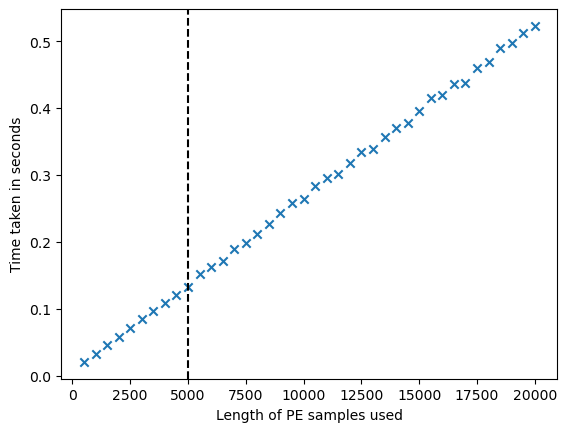

In [50]:
plt.scatter(length_arr, time_taken, marker='x')
#plt.plot(length_arr, time_taken, c='red', linestyle='dashed')
plt.axvline(5000, c='black', linestyle='dashed')
plt.xlabel("Length of PE samples used")
plt.ylabel("Time taken in seconds")

In [34]:
time_taken[-1]

0.5552034378051758

In [36]:
%%prun
zz = likelihood_object.parametrized_population.lnprior_and_transform_samples(mydf[0:20000], **test_hyp_dic, force_update=False)

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct[key] = val
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_

         1088200 function calls (1087991 primitive calls) in 0.751 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   120006    0.191    0.000    0.704    0.000 function_base.py:2356(func)
    99737    0.147    0.000    0.444    0.000 prior.py:811(lnprior)
    99776    0.113    0.000    0.113    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    99737    0.078    0.000    0.229    0.000 fromnumeric.py:71(_wrapreduction)
    99737    0.058    0.000    0.287    0.000 fromnumeric.py:2979(prod)
    20001    0.037    0.000    0.037    0.000 test_combined_priors.py:129(lnprior)
    99737    0.029    0.000    0.029    0.000 fromnumeric.py:72(<dictcomp>)
       10    0.029    0.003    0.739    0.074 function_base.py:2443(_vectorize_call)
   120006    0.024    0.000    0.024    0.000 {method 'update' of 'dict' objects}
    99737    0.010    0.000    0.010    0.000 fromnumeric.py:2974(_prod_dispatcher)
    99741    0.009    0.000  

In [17]:
likelihood_object.parametrized_population.subpriors[5].__dict__['hyper_params']

['chieff_mean', 'chieff_sigma']

In [12]:
likelihood_object

In [13]:
likelihood_object.lnlike(hyperparams_dic=test_hyp_dic)

/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_likelihood.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params_df[hyper_param] = np.full(len(params_df), hyperparams_dic[hyper_param])
/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_likelihood.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params_df[hyper_param] = np.full(len(params_df), hyperparams_dic[hype

KeyboardInterrupt: 

In [24]:
%debug

> /home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/gw_prior/extrinsic.py(33)time_delay_refdet()
     31     def time_delay_refdet(self, ra, dec):
     32         """Time delay from Earth center to the reference detector."""
---> 33         return lal.TimeDelayFromEarthCenter(self.ref_det_location, ra, dec,
     34                                             self.tgps)
     35 



ipdb>  len(ra)


5547


ipdb>  type(ra)


<class 'tuple'>
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [15]:
combined_pop_prior.hyper_prior_class().standard_params

['R', 'lambda1', 'lambda2']

In [13]:
combined_pop_prior

FixedTestPopulationPrior(m1, m2) → [iota, ra, dec, t_geocenter, psi, phi_ref, m1, m2, s1z, s2z, s1x_n, s1y_n, s2x_n, s2y_n, l1, l2, f_ref, d_luminosity]

In [ ]:
%debug

> /home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel/cogwheel/population_inference/population_models.py(217)lnprior_and_transform()
    215                                          + subprior.conditioned_on
    216                                          + hyperparam_list)}
--> 217                 lnp += subprior.lnprior(**input_dic)
    218             return lnp, standard_par_dic
    219 



ipdb>  input_dic


{'m1': 5.431003254248099, 'm2': 5.417386225076431}


## Test sampling posterior

In [ ]:
parentdir = '/home/isha/PopulationSelectionEffects/output/'
output_file_path = os.path.join(parentdir, 'test_population_sampler')

likelihood_object = PopulationLikelihood(test_gaussian_chieff_model, injections_summary_dict, all_events_pe, R0, injection_population_model=inj_prior)
post = PopulationPosterior(test_gaussian_chieff_model, likelihood_object)
pym = sampling.PyMultiNest(post)
pym.run_kwargs = {'n_iter_before_update': 1000,'n_live_points': 256,'evidence_tolerance': 0.25}
# perform the pe now
pym.run(output_file_path)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  256
 dimensionality =    3
 resuming from previous job
 *****************************************************


In [10]:
%debug

> /home/isha/miniconda3/envs/cogwheel_pop_latest/lib/python3.9/json/encoder.py(179)default()
    177 
    178         """
--> 179         raise TypeError(f'Object of type {o.__class__.__name__} '
    180                         f'is not JSON serializable')
    181 



ipdb>  o


          mchirp       lnq    chieff  cumchidiff  costheta_jn  phi_jl_hat  \
0      27.217838 -0.326421 -0.420744    0.473716     0.860835    2.808493   
1      27.883631 -1.415661 -0.047662    0.580546    -0.772647    2.123236   
2      31.593108 -1.652429  0.409053    0.808564    -0.872931    0.525684   
3      31.710681 -1.125810  0.261255    0.167585    -0.653827    0.520674   
4      39.650934 -0.516392  0.710368    0.106841     0.709171    4.964519   
...          ...       ...       ...         ...          ...         ...   
23611  31.321167 -0.168206 -0.039410    0.734120    -0.993314    3.515591   
23612  30.754612 -0.239442 -0.106582    0.975725    -0.996696    3.442664   
23613  30.764703 -0.122053 -0.086201    0.807027    -0.993592    4.396144   
23614  31.127652 -0.177470 -0.055071    0.974054    -0.994969    3.914445   
23615  30.733179 -0.197216 -0.109078    0.847996    -0.996324    2.816425   

          phi12  cums1r_s1z  cums2r_s2z       psi  ...  l1  l2  d_luminosit

In [11]:
injs_summary

,t_rec_h,t_rec_l,rhosq_rec_h,rhosq_rec_l,normfac_h,normfac_l,dphi_rec,sb_rec,inds,cosiota,...,phi_H,tgps,mchirp_id,dt_linfree,ln_pdet_fid,campaign,pdet_fid,dt_closest_inj,ifar,ifar_no_coherent_score
0,1.238473e+09,1.238473e+09,27.628481,37.071438,0.037273,0.046349,3.875179,0,501,-0.888970,...,3.227641,1.238473e+09,0,0.368423,10.445774,0,34398.684274,67.405310,0.023304,0.003070
1,1.239072e+09,1.239072e+09,91.873562,65.671602,0.036534,0.047152,3.674844,0,352,0.771037,...,1.264148,1.239072e+09,0,0.438106,8.512938,0,4978.767394,17.933630,2000.000000,2000.000000
2,1.239073e+09,1.239073e+09,193.084556,436.210652,0.035091,0.044498,2.759989,0,379,0.887409,...,6.001210,1.239073e+09,0,0.341748,7.952215,0,2841.863114,310.085190,2000.000000,2000.000000
3,1.238469e+09,1.238469e+09,41.169508,43.882219,0.038072,0.046100,2.802608,0,9,-0.402780,...,0.644813,1.238469e+09,0,0.475330,7.606454,0,2011.134375,27.957068,30.303030,17.391304
4,1.239153e+09,1.239153e+09,148.298027,215.183088,0.034462,0.045157,3.657669,0,242,-0.219944,...,0.377044,1.239153e+09,0,0.514418,6.589522,0,727.433317,654.664123,2000.000000,2000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,1.247676e+09,1.247676e+09,97.277315,181.830835,0.030357,0.044557,2.719269,7,12809,0.837646,...,5.212108,1.247676e+09,4,0.211836,8.243538,0,3802.972087,312.888192,500.000000,500.000000
1085,1.250341e+09,1.250341e+09,34.889917,25.704204,0.030042,0.044269,3.546493,7,9156,0.778787,...,0.412975,1.250341e+09,3,0.221310,7.309628,0,1494.620351,344.791194,0.489237,0.102260
1086,1.253612e+09,1.253612e+09,27.638619,46.924558,0.031741,0.043900,3.032013,7,20304,0.938999,...,0.659670,1.253612e+09,4,0.236611,8.714073,0,6087.985779,444.139942,1.434720,0.102844
1087,1.253933e+09,1.253933e+09,26.597797,41.193520,0.031277,0.045055,3.009324,7,18920,0.893897,...,3.350288,1.253933e+09,4,0.230194,9.495659,0,13301.852741,183.436154,0.507357,0.095584


## List manipulation test

In [10]:
import copy
ex = ['m', 'var', 'R']
ex_copy = copy.deepcopy(ex)

In [11]:
ex_copy.remove('R')

In [12]:
ex_copy

['m', 'var']

In [13]:
set(ex_copy) != set(ex)

True

In [14]:
ex_copy.remove('R')

ValueError: list.remove(x): x not in list